# Distributions

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ElementsOfDataScience/blob/v1/08_distributions.ipynb).

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/v1/utils.py')

import utils

In this chapter we'll see three ways to describe a distribution:

* A probability mass function (PMF), which represents a set of values and the number of times each one appears in a dataset.

* A cumulative distribution function (CDF), which contains the same information as a PMF in a form that makes it easier to visualize, make comparisons, and perform some computations.

* A kernel density estimate (KDE), which is like a smooth, continuous version of a histogram.

As examples, we'll use data from the General Social Survey (GSS) to look at distributions of age and income, and to explore the relationship between income and education.
But we'll start with one of the most important ideas in statistics, the distribution.

## Distributions

A distribution is a set of values and their corresponding probabilities.  For example, if you roll a six-sided die, there are six possible outcomes -- the numbers 1 through 6 -- and they all have the same probability, $1/6$.
We can represent this distribution of outcomes with a table, like this:


| Outcome       | 1     | 2     | 3     | 4     | 5     | 6     |
| :-----        | ----- | ----- | ----- | ----- | ----- | ----- |
| Probability   | 1/6   | 1/6   | 1/6   | 1/6   | 1/6   | 1/6   |


More generally, a distribution can have any number of values, the values can be any type, and the probabilities do not have to be equal.
To represent distributions in Python, we'll use a library called `empiricaldist`, which stands for "empirical distribution", where "empirical" means it is based on data rather than a mathematical formula.

The following cell checks whether `empiricaldist` is installed and installs it if necessary.

In [2]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

`empiricaldist` provides an object type called `Pmf`, which stands for "probability mass function".
A `Pmf` object contains a set of possible outcomes and their probabilities.
For example, here's a `Pmf` that represents the outcome of rolling a six-sided die:

In [3]:
from empiricaldist import Pmf

outcomes = [1,2,3,4,5,6]
die = Pmf(1/6, outcomes)

The first argument is the probability of the outcomes; the second argument is the list of outcomes.
We can display the result like this.

In [4]:
die

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


A `Pmf` object is a specialized version of a Pandas `Series`, so it provides all of the methods of a `Series`, plus some additional methods we'll see soon.

## The General Social Survey

We'll use `Pmf` objects to represent distributions of values from a new dataset, the General Social Survey (GSS).
The GSS surveys a representative sample of adult residents of the U.S. and asks questions about demographics, personal history, and beliefs about social and political issues.
It is widely used by politicians, policy makers, and researchers.

The GSS dataset contains hundreds of columns.
I've selected just a few and save the extract in an HDF file, which is more compact than the original fixed-width file, and faster to read.
Instructions for downloading the file are in the notebook for this chapter.

In [5]:
data_file = 'gss_extract_2022.hdf'

The following cells download the data extract.

In [6]:
download('https://github.com/AllenDowney/ElementsOfDataScience/raw/v1/data/' + data_file)

'gss_extract_2022.hdf'

We'll use the Pandas `read_hdf` function to read the data file and load `gss`, which is a `DataFrame`.

In [7]:
import pandas as pd

gss = pd.read_hdf(data_file, 'gss')
gss.shape

(72390, 9)

`gss` has one row for each respondent and one column for each question in the extract.
Here are the first few rows.

In [8]:
gss.head()

,year,id,age,educ,degree,sex,gunlaw,grass,realinc
0,1972,1,23.0,16.0,3.0,2.0,1.0,NaN,18951.0
1,1972,2,70.0,10.0,0.0,1.0,1.0,NaN,24366.0
2,1972,3,48.0,12.0,1.0,2.0,1.0,NaN,24366.0
3,1972,4,27.0,17.0,3.0,2.0,1.0,NaN,30458.0
4,1972,5,61.0,12.0,1.0,2.0,1.0,NaN,50763.0


I'll explain these columns as we go along, but if you want more information, you can read the online documentation at <https://gssdataexplorer.norc.org>.
In the GSS documentation, you'll see that they use the term "variable" for a column that contains answers to survey questions.

## Distribution of Education

To get started with this dataset, let's look at the `educ` column, which records the number of years of education for each respondent.
We can select this column from the `DataFrame` like this:

In [9]:
educ = gss['educ']

To see what the distribution of the responses looks like, we can use the `hist` method to plot a histogram.

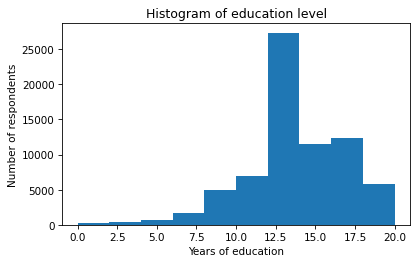

In [10]:
import matplotlib.pyplot as plt

educ.hist(grid=False)
plt.xlabel('Years of education')
plt.ylabel('Number of respondents')
plt.title('Histogram of education level');

Based on the histogram, we can see the general shape of the distribution and the central tendency -- it looks like the peak is near 12 years of education.
But a histogram is not the best way to visualize this distribution because it obscures some important details.

An alternative is to use a `Pmf` object.
The function `Pmf.from_seq` takes any kind of sequence -- like a list, tuple, or Pandas `Series` -- and computes the distribution of the values.

In [11]:
pmf_educ = Pmf.from_seq(educ, normalize=False)
type(pmf_educ)

empiricaldist.empiricaldist.Pmf

With the keyword argument `normalize=False`, the result contains counts rather than probabilities.
Here are the first few values in `educ` and their counts.

In [12]:
pmf_educ.head()

,probs
educ,
0.0,177
1.0,49
2.0,158


In this dataset, there are 177 respondents who report that they have no formal education, and 49 who have only one year.
Here are the last few values.

In [13]:
pmf_educ.tail()

,probs
educ,
18.0,2945
19.0,1112
20.0,1803


There are 1803 respondents who report that they have 20 or more years of formal education, which probably means they attended college and graduate school.
We can use the bracket operator to look up a value in `pmf_educ` and get the corresponding count.

In [14]:
pmf_educ[20]

1803

Often when we make a `Pmf`, we want to know the *fraction* of respondents with each value, rather than the counts.
We can do that by setting `normalize=True`.
Then we get a **normalized** `Pmf`, which means that the fractions add up to 1.

In [15]:
pmf_educ_norm = Pmf.from_seq(educ, normalize=True)
pmf_educ_norm.head()

,probs
educ,
0.0,0.002454
1.0,0.000679
2.0,0.002191


Now if we use the bracket operator to look up a value, the result is a fraction rather than a count.

In [16]:
pmf_educ_norm[20]

0.0249975737241255

The result indicates that about 2.5% of the respondents have 20 years of education.
But we can also interpret this result as a probability -- if we choose a random respondent, the probability is 2.5% that they have 20 years of education.

When a `Pmf` contains probabilities, we can say that it represents a proper probability mass function, or PMF.
With apologies for confusing notation, I'll use `Pmf` to mean a kind of Python object, and PMF to mean the concept of a probability mass function.

`Pmf` provides a `bar` method that plots the values and their probabilities as a bar chart.

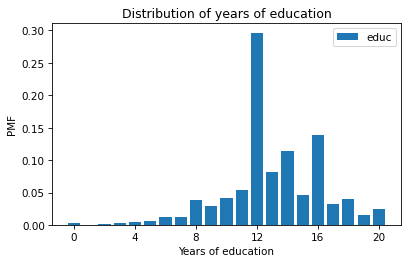

In [17]:
pmf_educ_norm.bar(label='educ')

plt.xlabel('Years of education')
plt.xticks(range(0, 21, 4))
plt.ylabel('PMF')
plt.title('Distribution of years of education')
plt.legend();

In this figure, we can see that the most common value is 12 years, but there are also peaks at 14 and 16, which correspond to two and four years of college.
For this data, plotting the `Pmf` is probably a better choice than the histogram.
The `Pmf` shows all unique values, so we can see where the peaks are.

**Exercise:** Let's look at the `year` column in the `DataFrame`, which represents the year each respondent was interviewed.
Make an unnormalized `Pmf` for `year` and plot the result as a bar chart.
Use the bracket operator to look up the number of respondents interviewed in 2022.

In [18]:
# Solution

# Compute the PMF for year
pmf_year = Pmf.from_seq(gss['year'], normalize=False)

# Display the result
pmf_year

,probs
year,
1972,1613
1973,1504
1974,1484
1975,1490
1976,1499
1977,1530
1978,1532
1980,1468
1982,1860


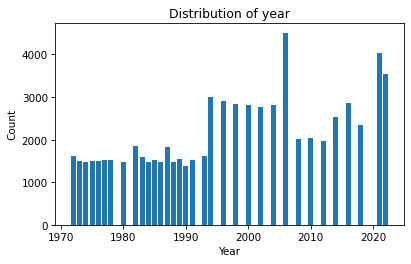

In [19]:
# Solution

pmf_year.bar()
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Distribution of year');

In [20]:
# Solution

pmf_year[2022]

3544

## Cumulative Distribution Functions

If we compute the cumulative sum of a PMF, the result is a cumulative distribution function (CDF).
To see what that means, and why it is useful, let's look at a simple example.
Suppose we have a sequence of five values.

In [21]:
values = 1, 2, 2, 3, 5  

Here's the `Pmf` of these values.

In [22]:
pmf = Pmf.from_seq(values)
pmf

,probs
1,0.2
2,0.4
3,0.2
5,0.2


If you draw a random value from `values`, the `Pmf` tells you the chance of getting `x`, for any value of `x`.

* The probability of the value `1` is `0.2`,

* The probability of the value `2` is `0.4`, and 

* The probabilities for `3` and `5` are `0.2` each.

The `Pmf` object has a method called `make_cdf` that computes the cumulative sum of the probabilities in the `Pmf` and returns a `Cdf` object.

In [23]:
cdf = pmf.make_cdf()
cdf

,probs
1,0.2
2,0.6
3,0.8
5,1.0


If you draw a random value from `values`, the `Cdf` tells you the chance of getting a value *less than or equal to* `x`, for any given `x`.

* The `Cdf` of `1` is `0.2` because one of the five values is less than or equal to 1,

* The `Cdf` of `2` is `0.6` because three of the five values are less than or equal to `2`,

* The `Cdf` of `3` is `0.8` because four of the five values are less than or equal to `3`,

* The `Cdf` of `5` is `1.0` because all of the values are less than or equal to `5`.

If we make a `Cdf` from a proper `Pmf`, where the probabilities add up to 1, the result represents a proper CDF.
As with `Pmf` and PMF, I'll use `Cdf` to refer to a Python object and CDF to refer to the concept.

## CDF of Age

To see why CDFs are useful, let's consider the distribution of ages for respondents in the General Social Survey.
The column we'll use is `age`.

Documentation of `age` is at <https://gssdataexplorer.norc.org/variables/53/vshow>.

According to the codebook, the range of the values is from `18` to `89`, where `89` means "89 or older".
The special codes `98` and `99` mean "Don't know" and "Didn't answer".
We can use `replace` to replace the special codes with `NaN`.

In [24]:
age = gss['age']

`empiricaldist` provides a `Cdf.from_seq` function that takes any kind of sequence and computes the CDF of the values.

In [25]:
from empiricaldist import Cdf

cdf_age = Cdf.from_seq(age)

The result is a `Cdf` object, which provides a method called `plot` that plots the CDF as a line.

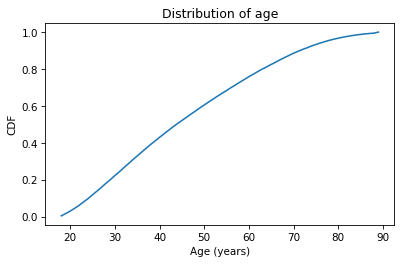

In [26]:
cdf_age.plot()

plt.xlabel('Age (years)')
plt.ylabel('CDF')
plt.title('Distribution of age');

The x-axis is the ages, from 18 to 89.
The y-axis is the cumulative probabilities, from 0 to 1.
The `Cdf` object can be used as a function, so if you give it an age, it returns the corresponding probability in a NumPy array.

In [27]:
q = 51
p = cdf_age(q)
p

array(0.62121445)

`q` stands for "quantity", which is another name for a value in a distribution.
`p` stands for probability, which is the result.
In this example, the quantity is age 51, and the corresponding probability is about 0.62.
That means that about 62% of the respondents are age 51 or younger.
The arrow in the following figure shows how you could read this value from the CDF, at least approximately.

In [28]:
def draw_line(p, q, x):
    xs = [q, q, x]
    ys = [0, p, p]
    plt.plot(xs, ys, ':', color='gray')

def draw_arrow_left(p, q, x):
    dx = 3
    dy = 0.025
    xs = [x+dx, x, x+dx]
    ys = [p-dy, p, p+dy]
    plt.plot(xs, ys, ':', color='gray')
    
def draw_arrow_down(p, q, y):
    dx = 1.25
    dy = 0.045
    xs = [q-dx, q, q+dx]
    ys = [y+dy, y, y+dy]
    plt.plot(xs, ys, ':', color='gray')

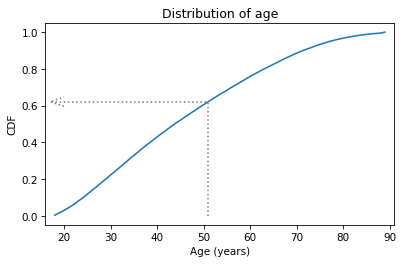

In [29]:
cdf_age.plot()

x = 17
draw_line(p, q, x)
draw_arrow_left(p, q, x)

plt.xlabel('Age (years)')
plt.xlim(x-1, 91)
plt.ylabel('CDF')
plt.title('Distribution of age');

The CDF is an invertible function, which means that if you have a probability, `p`, you can look up the corresponding quantity, `q`.
The `Cdf` object provides a method called `inverse` that computes the inverse of the cumulative distribution function.

In [30]:
p1 = 0.25
q1 = cdf_age.inverse(p1)
q1

array(32.)

In this example, we look up the probability 0.25 and the result is 32.
That means that 25% of the respondents are age 32 or less.
Another way to say the same thing is "age 32 is the 25th percentile of this distribution".

If we look up probability 0.75, it returns 60, so 75% of the respondents are 60 or younger.

In [31]:
p2 = 0.75
q2 = cdf_age.inverse(p2)
q2

array(60.)

In the following figure, the arrows show how you could read these values from the CDF.

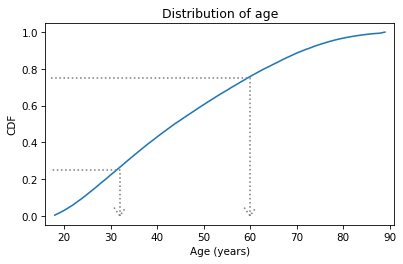

In [32]:
cdf_age.plot()

x = 17
draw_line(p1, q1, x)
draw_arrow_down(p1, q1, 0)

draw_line(p2, q2, x)
draw_arrow_down(p2, q2, 0)

plt.xlabel('Age (years)')
plt.xlim(x-1, 91)
plt.ylabel('CDF')
plt.title('Distribution of age');

The distance from the 25th to the 75th percentile is called the **interquartile range** or IQR.
It measures the spread of the distribution, so it is similar to standard deviation or variance.
Because it is based on percentiles, it doesn't get thrown off by outliers as much as standard deviation does.
So IQR is more **robust** than variance, which means it works well even if there are errors in the data or extreme values.

**Exercise:**  Using `cdf_age`, compute the fraction of respondents in the GSS dataset who are *older* than `65`.
Recall that the CDF computes the fraction who are less than or equal to a value, so the complement is the fraction who exceed a value.

In [33]:
# Solution

1 - cdf_age(65)

0.17525586071124388

**Exercise:** The distribution of income in almost every country is long-tailed, which means there are a small number of people with very high incomes.
In the GSS dataset, the `realinc` column represents total household income, converted to 1986 dollars.
We can get a sense of the shape of this distribution by plotting the CDF.
Select `realinc` from the `gss` dataset, make a `Cdf` called `cdf_income`, and plot it.  Remember to label the axes!

Because the tail of the distribution extends to the right, the mean is greater than the median.
Use the `Cdf` object to compute the fraction of respondents whose income is at or below the mean. 

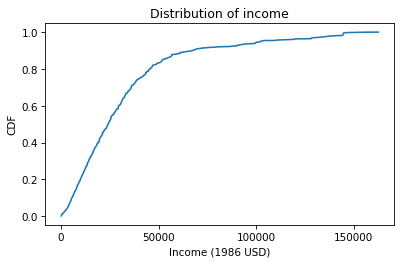

In [34]:
# Solution

# Select realinc
realinc = gss['realinc']

# Make the CDF
cdf_income = Cdf.from_seq(realinc)

# Plot it
cdf_income.plot()

# Label the axes
plt.xlabel('Income (1986 USD)')
plt.xticks(range(0, 160000, 50000))
plt.ylabel('CDF')
plt.title('Distribution of income');

In [35]:
# Solution

cdf_income(realinc.mean())

array(0.64479603)

## Comparing Distributions

So far we've seen two ways to represent distributions, PMFs and CDFs.
Now we'll use PMFs and CDFs to compare distributions, and we'll see the pros and cons of each.
One way to compare distributions is to plot multiple PMFs on the same axes.
For example, suppose we want to compare the distribution of age for male and female respondents.
First we'll create a Boolean `Series` that's true for male respondents and another that's true for female respondents.

In [36]:
male = (gss['sex'] == 1)
female = (gss['sex'] == 2)

We can use these `Series` to select ages for male and female respondents.

In [37]:
male_age = age[male]
female_age = age[female]

And plot a PMF for each.

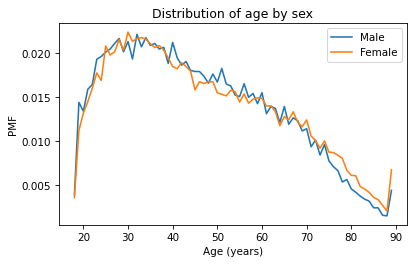

In [38]:
pmf_male_age = Pmf.from_seq(male_age)
pmf_male_age.plot(label='Male')

pmf_female_age = Pmf.from_seq(female_age)
pmf_female_age.plot(label='Female')

plt.xlabel('Age (years)') 
plt.ylabel('PMF')
plt.title('Distribution of age by sex')
plt.legend();

A plot as variable as this is often described as **noisy**.
If we ignore the noise, it looks like the PMF is higher for men between ages 40 and 50, 
and higher for women between ages 70 and 80.
But both of those differences might be due to randomness.

Now let's do the same thing with CDFs -- everything is the same except we replace `Pmf` with `Cdf`.

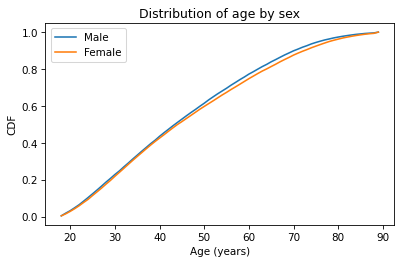

In [39]:
cdf_male_age = Cdf.from_seq(male_age)
cdf_male_age.plot(label='Male')

cdf_female_age = Cdf.from_seq(female_age)
cdf_female_age.plot(label='Female')

plt.xlabel('Age (years)') 
plt.ylabel('CDF')
plt.title('Distribution of age by sex')
plt.legend();

Because CDFs smooth out randomness, they provide a better view of real differences between distributions.
In this case, the lines are close together until age 40 -- after that, the CDF is higher for men than women.

So what does that mean?
One way to interpret the difference is that the fraction of men below a given age is generally more than the fraction of women below the same age.
For example, about 79% of men are 60 or less, compared to 76% of women.

In [40]:
cdf_male_age(60), cdf_female_age(60)

(array(0.7721998), array(0.7474241))

Going the other way, we could also compare percentiles.
For example, the median age woman is older than the median age man, by about one year.

In [41]:
cdf_male_age.inverse(0.5), cdf_female_age.inverse(0.5)

(array(44.), array(45.))

**Exercise:** What fraction of men are over 80?  What fraction of women?

In [42]:
# Solution

1-cdf_male_age(80), 1-cdf_female_age(80)

(0.026898335015136277, 0.03813081300609189)

## Comparing Incomes

As another example, let's look at household income and compare the distribution before and after 1995 (I chose 1995 because it's roughly the midpoint of the survey).
We'll make two Boolean `Series` objects to select respondents interviewed before and after 1995.

In [43]:
pre95 = (gss['year'] < 1995)
post95 = (gss['year'] >= 1995)

Now we can plot the PMFs of `realinc`, which records household income converted to 1986 dollars.

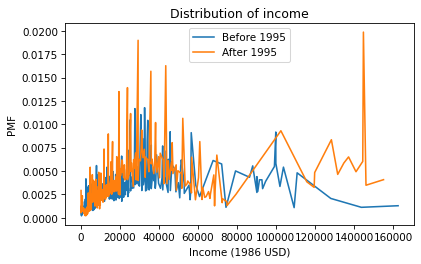

In [44]:
realinc = gss['realinc']

Pmf.from_seq(realinc[pre95]).plot(label='Before 1995')
Pmf.from_seq(realinc[post95]).plot(label='After 1995')

plt.xlabel('Income (1986 USD)')
plt.ylabel('PMF')
plt.title('Distribution of income')
plt.legend();

There are a lot of unique values in this distribution, and none of them appear very often.  As a result, the PMF is so noisy and we can't really see the shape of the distribution.
It's also hard to compare the distributions.
It looks like there are more people with high incomes after 1995, but it's hard to tell.  We can get a clearer picture with a CDF.

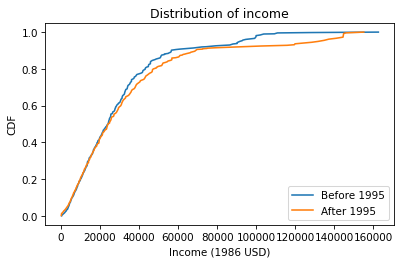

In [45]:
Cdf.from_seq(realinc[pre95]).plot(label='Before 1995')
Cdf.from_seq(realinc[post95]).plot(label='After 1995')

plt.xlabel('Income (1986 USD)')
plt.ylabel('CDF')
plt.title('Distribution of income')
plt.legend();

Below $30,000 the CDFs are almost identical; above that, we can see that the post-1995 distribution is shifted to the right.
In other words, the fraction of people with high incomes is about the same, but the income of high earners has increased.

In general, I recommend CDFs for exploratory analysis.
They give you a clear view of the distribution, without too much noise, and they are good for comparing distributions.

**Exercise:** Let's compare incomes for different levels of education in the GSS dataset.
We'll use the `degree` column, which represents the highest degree each respondent has earned.
In this column, the value `1` indicates a high school diploma, `2` indicates an Associate's degree, and `3` indicates a Bachelor's degree.

Compute and plot the distribution of income for each group.
Remember to label the CDFs, display a legend, and label the axes.
Write a few sentences that describe and interpret the results.

In [46]:
# You can use the following Boolean Series objects to select groups from `realinc`

# Select educ
degree = gss['degree']

# Bachelor's degree
bach = (degree == 3)

# Associate degree
assc = (degree == 2)

# High school
high = (degree == 1)

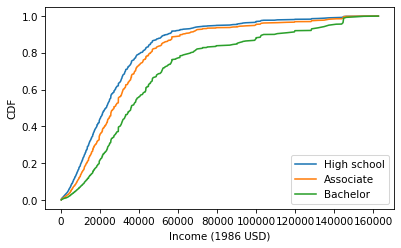

In [47]:
# Solution

# Plot the CDFs
Cdf.from_seq(realinc[high]).plot(label='High school')
Cdf.from_seq(realinc[assc]).plot(label='Associate')
Cdf.from_seq(realinc[bach]).plot(label='Bachelor')

# Label the axes
plt.xlabel('Income (1986 USD)')
plt.ylabel('CDF')
plt.legend();

In [48]:
# Solution

"""
At almost every percentile level, people with more education report higher incomes.

It is plausible that college degrees help people get higher-paying jobs,
but we should be careful not to assume that that is the only cause-and-effect 
relationship that contributes to this difference.

People who have the opportunity to go to college, choose to do so, and earn a
degree might have other resources and attributes that contribute to their income
later in life.
""";

## Modeling Distributions

Some distributions have names.
For example, you might be familiar with the normal distribution, also called the Gaussian distribution or the bell curve.
And you might have heard of others like the exponential distribution, binomial distribution, or maybe Poisson distribution.
These "distributions with names" are called **theoretical** because they are based on mathematical functions, as contrasted with empirical distributions, which are based on data.

Many things we measure have distributions that are well approximated by theoretical distributions, so these distributions are sometimes good models for the real world.
In this context, what I mean by a **model** is a simplified description of the world that is accurate enough for its intended purpose.

To check whether a theoretical distribution is a good model for a dataset, we can compare the CDF of the data to the CDF of a normal distribution with the same mean and standard deviation.
I'll demonstrate with a sample from a normal distribution, then we'll try it with real data.

The following statement uses NumPy's `random` library to generate 1000 values from a normal distribution with mean 10 and standard deviation 1.

In [49]:
import numpy as np

np.random.seed(17)

In [50]:
sample = np.random.normal(10, 1, size=1000)

Here's what the empirical distribution of the sample looks like.

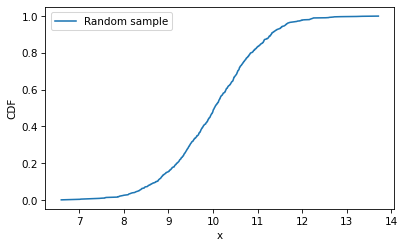

In [51]:
cdf_sample = Cdf.from_seq(sample)
cdf_sample.plot(label='Random sample')

plt.xlabel('x')
plt.ylabel('CDF')
plt.legend();

Now let's compute the CDF of a normal distribution with the actual values of the mean and standard deviation.

In [52]:
from scipy.stats import norm

qs = np.linspace(6, 14)
ps = norm(10, 1).cdf(qs)

First we import `norm` from `scipy.stats`, which is a collection of functions related to statistics.
Then we use `linspace()` to create an array of equally-spaced values from -3 to 3 -- those are the `qs` where we will evaluate the normal CDF.
Next, `norm(10, 1)` creates an object that represents a normal distribution with mean 10 and standard deviation 1.
Finally, `cdf` computes the CDF of the normal distribution, evaluated at each of the `qs`.

I'll plot the normal CDF with a gray line and then plot the CDF of the data again.

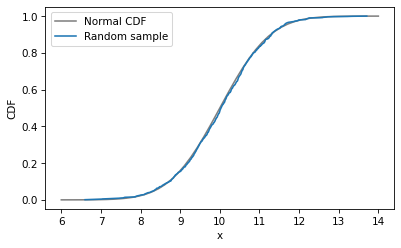

In [53]:
plt.plot(qs, ps, color='gray', label='Normal CDF')
cdf_sample.plot(label='Random sample')

plt.xlabel('x')
plt.ylabel('CDF')
plt.legend();

The CDF of the random sample agrees with the normal model -- which is not surprising because the data were actually sampled from a normal distribution.
When we collect data in the real world, we do not expect it to fit a normal distribution as well as this.
In the next exercise, we'll try it and see. 

**Exercise:** In many datasets, the distribution of income is approximately **lognormal**, which means that the logarithms of the incomes fit a normal distribution.  Let's see whether that's true for the GSS data. 

* Extract `realinc` from `gss` and compute the logarithms of the incomes using `np.log10()`.

* Compute the mean and standard deviation of the log-transformed incomes.

* Use `norm` to make a normal distribution with the same mean and standard deviation as the log-transformed incomes.

* Plot the CDF of the normal distribution.

* Compute and plot the CDF of the log-transformed incomes.

How similar are the CDFs of the log-transformed incomes and the normal distribution?

In [54]:
# Extract realinc and compute its log

realinc = gss['realinc']
log_realinc = np.log10(realinc)

In [55]:
# Solution

# Compute mean and standard deviation
mean = log_realinc.mean()
std = log_realinc.std()
print(mean, std)

4.323651324673204 0.45382159053879434


In [56]:
# Solution

# Evaluate the model CDF
xs = np.linspace(2, 5.5)
ys = norm(mean, std).cdf(xs)

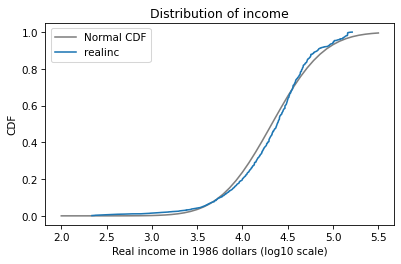

In [57]:
# Solution

# Plot the model CDF
plt.plot(xs, ys, color='gray', label='Normal CDF')

# Create and plot the Cdf of log_realinc
Cdf.from_seq(log_realinc).plot(label='realinc')
    
# Label the axes
plt.xlabel('Real income in 1986 dollars (log10 scale)')
plt.ylabel('CDF')
plt.title('Distribution of income')
plt.legend();

In [58]:
# Solution

# The normal distribution fits the logarithms of income well enough that we
# could say it is a good, but not perfect, model for the data.

## Kernel Density Estimation

We have seen two ways to represent distributions, PMFs and CDFs.
Now we'll learn another way: a probability density function, or PDF.
The `norm` function, which we used to compute the normal CDF, can also compute the normal PDF.

In [59]:
xs = np.linspace(6, 14)
ys = norm(10, 1).pdf(xs)

Here's what it looks like.

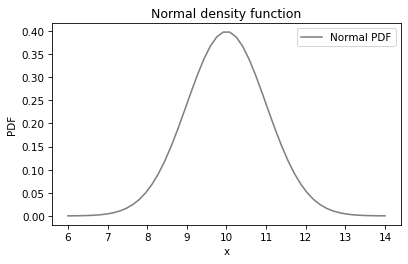

In [60]:
plt.plot(xs, ys, color='gray', label='Normal PDF')

plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Normal density function')
plt.legend();

The normal PDF is the classic "bell curve".
Now, it is tempting to compare the PMF of the data to the PDF of the normal distribution, but that doesn't work.
Let's see what happens if we try:

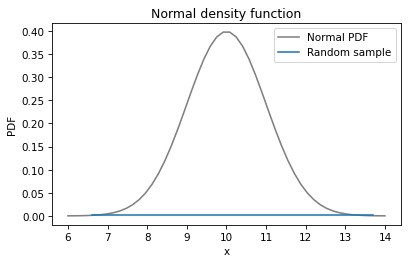

In [61]:
plt.plot(xs, ys, color='gray', label='Normal PDF')

pmf_sample = Pmf.from_seq(sample)
pmf_sample.plot(label='Random sample')

plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Normal density function')
plt.legend();

The PMF of the sample is a flat line across the bottom.
In the random sample, every value is unique, so they all have the same probability, one in 1000.

However, we can use the points in the sample to estimate the PDF of the distribution they came from.
This process is called **kernel density estimation**, or KDE.
To generate a KDE plot, we'll use the Seaborn library, imported as `sns`.
Seaborn provides `kdeplot`, which takes the sample, estimates the PDF, and plots it.

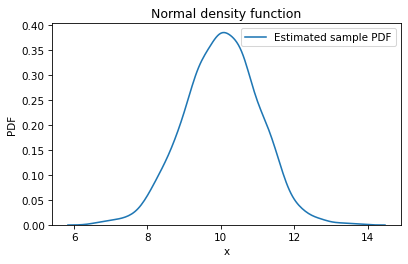

In [62]:
import seaborn as sns

sns.kdeplot(sample, label='Estimated sample PDF')

plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Normal density function')
plt.legend();

Now we can compare the KDE plot and the normal PDF.

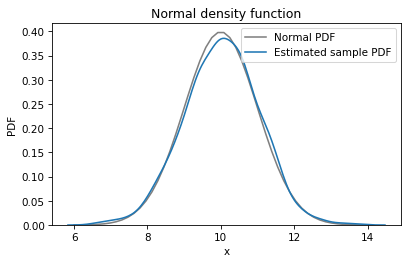

In [63]:
plt.plot(xs, ys, color='gray', label='Normal PDF')
sns.kdeplot(sample, label='Estimated sample PDF')

plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Normal density function')
plt.legend();

The KDE plot matches the normal PDF well.
We can see places where the data deviate from the model, but because we know the data really came from a normal distribution, we know those deviations are due to random sampling.

Comparing PDFs is a sensitive way to look for differences, but often it is too sensitive -- it can be hard to tell whether apparent differences mean anything, or if they are just random, as in this case.

**Exercise:** In a previous exercise, we used CDFs to see if the distribution of income fits a lognormal distribution.  We can make the same comparison using a PDF and KDE.

* Again, extract `realinc` from `gss` and compute its logarithm using `np.log10()`.

* Compute the mean and standard deviation of the log-transformed incomes.

* Use `norm` to make a normal distribution with the same mean and standard deviation as the log-transformed incomes.

* Plot the PDF of the normal distribution.

* Use `sns.kdeplot()` to estimate and plot the density of the log-transformed incomes.

In [64]:
# Extract realinc and compute its log

realinc = gss['realinc']
log_realinc = np.log10(realinc)

In [65]:
# Solution

# Compute mean and standard deviation
mean = log_realinc.mean()
std = log_realinc.std()
print(mean, std)

4.323651324673204 0.45382159053879434


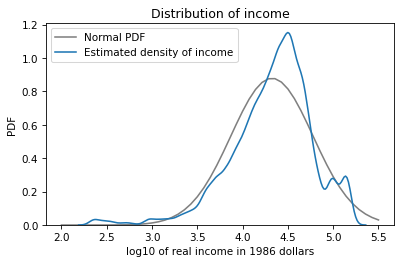

In [66]:
# Solution

# Evaluate the normal PDF
xs = np.linspace(2, 5.5)
ys = norm(mean, std).pdf(xs)

# Plot the model PDF
plt.plot(xs, ys, color='gray', label='Normal PDF')

# Plot the data KDE
sns.kdeplot(log_realinc.dropna(), 
            label='Estimated density of income')
    
# Label the axes
plt.xlabel('log10 of real income in 1986 dollars')
plt.ylabel('PDF')
plt.title('Distribution of income')
plt.legend();

In [67]:
# Solution

"""
In this example, the deviations from the model are substantial enough that they
are probably not just random. Deviations like that are common with real data --
sometimes a normal distribution is a good model for data, but the real world is
not obligated to fit simple models.
""";


## Summary

In this chapter, we've seen three ways to visualize distributions: PMFs, CDFs, and KDE plots.
In general, I use CDFs when I am exploring data -- that way, I get the best view of what's going on without getting distracted by noise.
Then, if I am presenting results to an audience unfamiliar with CDFs, I might use a PMF if the dataset contains a small number of unique values, or KDE if there are many unique values.

*Elements of Data Science*

Copyright 2021 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)